# Data description & Problem statement: 
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

The type of dataset and problem is a classic supervised binary classification. Given a number of elements all with certain characteristics (features), we want to build a machine learning model to identify people affected by type 2 diabetes.


# Workflow:
- Load the dataset, and define the required functions (e.g. for detecting the outliers)
- Data Cleaning/Wrangling: Manipulate outliers, missing data or duplicate values, Encode categorical variables, etc.
- Split data into training & test parts (utilize the training part for training & hyperparameter tuning of model, and test part for the final evaluation of model)
   #  Model Training:
- Build an initial XGBoost model, and evaluate it via C-V approach
- Use grid-search along with C-V approach to find the best hyperparameters of XGBoost model: Find the best XGBoost model (Note: I've utilized SMOTE technique via imblearn toolbox to synthetically over-sample the minority category and even the dataset imbalances.)
   # Model Evaluation: 
- Evaluate the best XGBoost model with optimized hyperparameters on Test Dataset, by calculating:
     - AUC score
     - Confusion matrix
     - ROC curve  
     - Precision-Recall curve 
     - Average precision
     
Finally, calculate the Feature Importance. 

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Function to remove outliers (all rows) by Z-score: 
def remove_outliers(X, y, name, thresh=3):
    L=[]
    for name in name:
        drop_rows = X.index[(np.abs(X[name] - X[name].mean()) >= (thresh * X[name].std()))]
        L.extend(list(drop_rows))
        
    X.drop(np.array(list(set(L))), axis=0, inplace=True)
    y.drop(np.array(list(set(L))), axis=0, inplace=True)
    print('number of outliers removed :  ' , len(L))

In [3]:
df=pd.read_csv('C:/Users/rhash/Documents/Datasets/pima-indian-diabetes/indians-diabetes.csv') 

df.columns=['NP', 'GC', 'BP', 'ST', 'I',  'BMI', 'PF', 'Age', 'Class']

# To Shuffle the data:
np.random.seed(42)
df=df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
NP       768 non-null int64
GC       768 non-null int64
BP       768 non-null int64
ST       768 non-null int64
I        768 non-null int64
BMI      768 non-null float64
PF       768 non-null float64
Age      768 non-null int64
Class    768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df['ST'].replace(0, df[df['ST']!=0]['ST'].mean(), inplace=True)
df['GC'].replace(0, df[df['GC']!=0]['GC'].mean(), inplace=True)
df['BP'].replace(0, df[df['BP']!=0]['BP'].mean(), inplace=True)
df['BMI'].replace(0, df[df['BMI']!=0]['BMI'].mean(), inplace=True)
df['I'].replace(0, df[df['I']!=0]['I'].mean(), inplace=True)

In [5]:
df.head()

,NP,GC,BP,ST,I,BMI,PF,Age,Class
0,6,148.0,72.0,35.00000,155.548223,33.6,0.627,50,1
1,1,85.0,66.0,29.00000,155.548223,26.6,0.351,31,0
2,8,183.0,64.0,29.15342,155.548223,23.3,0.672,32,1
3,1,89.0,66.0,23.00000,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.00000,168.000000,43.1,2.288,33,1


In [6]:
X=df.drop('Class', axis=1)
y=df['Class']

# We initially devide data into training & test folds: We do the Grid-Search only on training part  
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

#remove_outliers(X_train, y_train, ['NP', 'GC', 'BP', 'ST', 'I',  'BMI', 'PF', 'Age'], thresh=5)

In [7]:
# Building the Initial Model & Cross-Validation: 
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

model=XGBClassifier() 
kfold=StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
scores=cross_val_score(model, X_train, y_train, cv=kfold)

print(scores, "\n")
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

[0.75172414 0.77083333 0.76388889 0.79020979] 

Accuracy: 0.77 (+/- 0.01)


In [8]:
# Grid-Search for the best model parameters: 

# We create a sample_weight list for this imbalanced dataset:
from sklearn.utils.class_weight import compute_sample_weight
sw=compute_sample_weight(class_weight='balanced', y=y_train)


from sklearn.model_selection import GridSearchCV
param={'max_depth':[2, 4, 6, 8], 'min_child_weight':[1, 2, 3], 'gamma': [ 0, 0.05, 0.1], 'subsample':[0.7, 1]}

kfold=StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search=GridSearchCV(XGBClassifier(), param, cv=kfold, n_jobs=-1, scoring="roc_auc")
grid_search.fit(X_train, y_train, sample_weight=sw)

# Grid-Search report: 
G=pd.DataFrame(grid_search.cv_results_).sort_values("rank_test_score")
G.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_max_depth,param_min_child_weight,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
1,0.024303,0.000701,0.002315,4.676057e-04,0,2,1,1,"{'gamma': 0, 'max_depth': 2, 'min_child_weight...",0.813254,0.805373,0.855761,0.824796,0.022131,1,0.951254,0.953612,0.93997,0.948279,0.005953
49,0.024965,0.000619,0.002480,2.247832e-07,0.1,2,1,1,"{'gamma': 0.1, 'max_depth': 2, 'min_child_weig...",0.813254,0.805373,0.855761,0.824796,0.022131,1,0.951254,0.953612,0.93997,0.948279,0.005953
25,0.024965,0.000468,0.002315,2.337748e-04,0.05,2,1,1,"{'gamma': 0.05, 'max_depth': 2, 'min_child_wei...",0.813254,0.805373,0.855761,0.824796,0.022131,1,0.951254,0.953612,0.93997,0.948279,0.005953


In [9]:
print("Best parameters: ", grid_search.best_params_)
print("Best validation accuracy:  %0.2f (+/- %0.2f)" % (np.round(grid_search.best_score_, decimals=2), np.round(G.loc[grid_search.best_index_,"std_test_score" ], decimals=2)))
print("Test score: ", np.round(grid_search.score(X_test, y_test),2))

Best parameters:  {'gamma': 0, 'max_depth': 2, 'min_child_weight': 1, 'subsample': 1}
Best validation accuracy:  0.82 (+/- 0.02)
Test score:  0.82


Confusion matrix, without normalization
[[92 33]
 [22 45]]
Normalized confusion matrix
[[0.74 0.26]
 [0.33 0.67]]


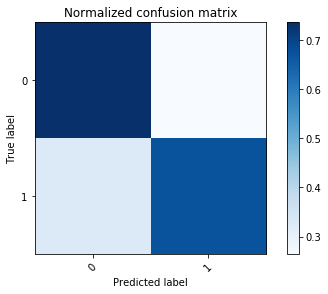

In [10]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

names = ["0", "1"]

# Compute confusion matrix
cm = confusion_matrix(y_test, grid_search.predict(X_test))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, names, title='Normalized confusion matrix')

plt.show()

In [11]:
# Classification report:
report=classification_report(y_test, grid_search.predict(X_test))
print(report)

             precision    recall  f1-score   support

          0       0.81      0.74      0.77       125
          1       0.58      0.67      0.62        67

avg / total       0.73      0.71      0.72       192



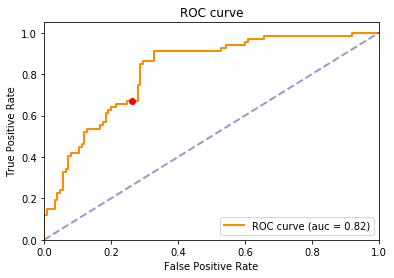

In [12]:
# ROC curve & auc:
from  sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score

fpr, tpr, thresholds=roc_curve(np.array(y_test),grid_search.predict_proba(X_test)[:, 1] , pos_label=1)
roc_auc=roc_auc_score(np.array(y_test), grid_search.predict_proba(X_test)[:, 1])

plt.figure()

plt.step(fpr, tpr, color='darkorange', lw=2, label='ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

plt.plot([cm_normalized[0,1]], [cm_normalized[1,1]], 'or')
plt.show()

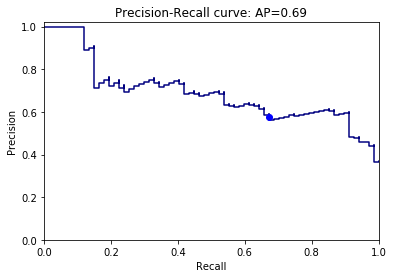

In [13]:
# Precision-Recall trade-off:
precision, recall, thresholds=precision_recall_curve(y_test,grid_search.predict_proba(X_test)[:, 1],  pos_label=1)
ave_precision=average_precision_score(y_test,grid_search.predict_proba(X_test)[:, 1])

plt.step(recall, precision, color='navy')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0, 1.001])
plt.ylim([0, 1.02])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(ave_precision))

plt.plot([cm_normalized[1,1]], [cm[1,1]/(cm[1,1]+cm[0,1])], 'ob')
plt.show()

('PF', 0.18965517)
('GC', 0.18275861)
('BMI', 0.1724138)
('I', 0.13103448)
('Age', 0.112068966)
('NP', 0.0862069)
('ST', 0.077586204)
('BP', 0.048275862)


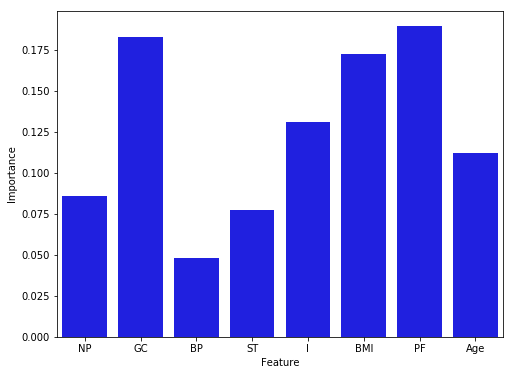

In [14]:
# Feature Importance:
im=XGBClassifier().fit(X,y).feature_importances_

# Sort & Plot:
d=dict(zip(np.array(X.columns), im))
k=sorted(d,key=lambda i: d[i], reverse= True)
[print((i,d[i])) for i in k]

# Plot:
c1=pd.DataFrame(np.array(im),  columns=["Importance"])
c2=pd.DataFrame(np.array(X.columns[0:8]),columns=["Feature"])

fig, ax = plt.subplots(figsize=(8,6)) 
sns.barplot(x="Feature", y="Importance", data=pd.concat([c2,c1], axis=1), color="blue", ax=ax)